In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn import utils
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from keras import datasets, layers, models
from keras.layers import Conv2D, MaxPooling2D,Dropout,Flatten,Dense
import glob
from scipy import stats
import datetime as dt

In [2]:
# Load data from csv 3 files
# acceleration.txt, heartrate.txt, labeled_sleep.txt
ACC = pd.read_csv('acceleration.txt', sep = ' ',names=['timedelta', 'accX', 'accY', 'accZ'])
HeartR = pd.read_csv('heartrate.txt', sep = ',',names=['timedelta', 'heartrate'])
SleepL = pd.read_csv('labeled_sleep.txt', sep = ' ',names=['timedelta', 'sleep'])

In [3]:
# Check ‘timedelta’ max(), min() of ACC, HeartR, SleepL (ช่วงเวลาที่มีข้อมูลใกล้กัน)
ACC_max_date = ACC['timedelta'].max()
ACC_min_date = ACC['timedelta'].min()
HeartR_max_date = HeartR['timedelta'].max()
HeartR_min_date = HeartR['timedelta'].min()
SleepL_max_date = SleepL['timedelta'].max()
SleepL_min_date = SleepL['timedelta'].min()

In [4]:
print('ACC start: ',ACC_min_date,'ACC end: ',ACC_max_date)
print('HeartR start: ',HeartR_min_date,'HeartR end: ',HeartR_max_date)
print('SleepL start: ',SleepL_min_date,'SleepL end: ',SleepL_max_date)

ACC start:  -124489.16105 ACC end:  17643.046417
HeartR start:  -556410.36066 HeartR end:  16980.47229
SleepL start:  0 SleepL end:  16980


In [5]:
ACC_new = ACC[(ACC["timedelta"]> ACC_min_date) & (ACC["timedelta"] < ACC_max_date) & (ACC["timedelta"]> HeartR_min_date) & (ACC["timedelta"] < HeartR_max_date) &(ACC["timedelta"]> SleepL_min_date) & (ACC["timedelta"] < SleepL_max_date)]
HeartR_new = HeartR[(HeartR["timedelta"]> ACC_min_date) & (HeartR["timedelta"] < ACC_max_date) & (HeartR["timedelta"]> HeartR_min_date) & (HeartR["timedelta"] < HeartR_max_date) &(HeartR["timedelta"]> SleepL_min_date) & (HeartR["timedelta"] < SleepL_max_date)]
SleepL_new = SleepL[(SleepL["timedelta"]> ACC_min_date) & (SleepL["timedelta"] < ACC_max_date) & (SleepL["timedelta"]> HeartR_min_date) & (SleepL["timedelta"] < HeartR_max_date) &(SleepL["timedelta"]> SleepL_min_date) & (SleepL["timedelta"] < SleepL_max_date)]


In [6]:
# Convert to datetime and round to second,
ACC_new['timedelta'] = pd.DataFrame(pd.to_timedelta(ACC_new['timedelta'], 'seconds').round('1s'))
HeartR_new['timedelta'] = pd.DataFrame(pd.to_timedelta(HeartR_new['timedelta'], 'seconds').round('1s'))
SleepL_new['timedelta'] = pd.DataFrame(pd.to_timedelta(SleepL_new['timedelta'], 'seconds').round('1s'))

C:\Users\ACER\AppData\Local\Temp\ipykernel_29464\1343708758.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ACC_new['timedelta'] = pd.DataFrame(pd.to_timedelta(ACC_new['timedelta'], 'seconds').round('1s'))
C:\Users\ACER\AppData\Local\Temp\ipykernel_29464\1343708758.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HeartR_new['timedelta'] = pd.DataFrame(pd.to_timedelta(HeartR_new['timedelta'], 'seconds').round('1s'))
C:\Users\ACER\AppData\Local\Temp\ipykernel_29464\1343708758.py:4: SettingWithCopyWarni

In [7]:
# Average rounding duplicated time
df_acc_X = ACC_new.groupby('timedelta')['accX'].mean()
df_acc_Y = ACC_new.groupby('timedelta')['accY'].mean()
df_acc_Z = ACC_new.groupby('timedelta')['accZ'].mean()

In [8]:
ACC_new_2 = pd.concat([df_acc_X, df_acc_Y, df_acc_Z], axis=1).reset_index()

In [9]:
ACC_new_2['timedelta'] = ACC_new_2['timedelta'] - ACC_new_2['timedelta'].min()

In [10]:
df_heartrate = HeartR_new.groupby('timedelta')['heartrate'].mean()
resample_rule = '1s'
HeartR_new2 = HeartR_new.set_index('timedelta').resample(resample_rule,).median().ffill()
HeartR_new2

,heartrate
timedelta,
0 days 00:00:08,97.0
0 days 00:00:09,97.0
0 days 00:00:10,97.0
0 days 00:00:11,97.0
0 days 00:00:12,97.0
...,...
0 days 04:42:51,75.0
0 days 04:42:52,75.0
0 days 04:42:53,75.0


In [11]:
#Resampling every 1s with median with ffill
df_heartrate = HeartR_new.groupby('timedelta')['heartrate'].mean()

resample_rule = '1s'
HeartR_new2 = HeartR_new.set_index('timedelta').resample(resample_rule,).median().ffill()
HeartR_new_2 = pd.concat([HeartR_new2], axis=1).reset_index()
HeartR_new_2['timedelta'] = HeartR_new_2['timedelta']-HeartR_new_2['timedelta'].min()
HeartR_new_2

,timedelta,heartrate
0,0 days 00:00:00,97.0
1,0 days 00:00:01,97.0
2,0 days 00:00:02,97.0
3,0 days 00:00:03,97.0
4,0 days 00:00:04,97.0
...,...,...
16963,0 days 04:42:43,75.0
16964,0 days 04:42:44,75.0
16965,0 days 04:42:45,75.0
16966,0 days 04:42:46,75.0


In [12]:
resample_rule = '1s'
SleepL_new2 = SleepL_new.set_index('timedelta').resample(resample_rule,).median().ffill()
SleepL_new2

,sleep
timedelta,
0 days 00:00:30,-1.0
0 days 00:00:31,-1.0
0 days 00:00:32,-1.0
0 days 00:00:33,-1.0
0 days 00:00:34,-1.0
...,...
0 days 04:42:26,0.0
0 days 04:42:27,0.0
0 days 04:42:28,0.0


In [13]:
df_SleepL = SleepL_new.groupby('timedelta')['sleep'].mean()
resample_rule = '1s'
SleepL_new2 = SleepL_new.set_index('timedelta').resample(resample_rule,).median().ffill()
SleepL_new_2 = pd.concat([SleepL_new2], axis=1).reset_index()
SleepL_new_2['timedelta'] = SleepL_new_2['timedelta']-SleepL_new_2['timedelta'].min()
SleepL_new_2

,timedelta,sleep
0,0 days 00:00:00,-1.0
1,0 days 00:00:01,-1.0
2,0 days 00:00:02,-1.0
3,0 days 00:00:03,-1.0
4,0 days 00:00:04,-1.0
...,...,...
16916,0 days 04:41:56,0.0
16917,0 days 04:41:57,0.0
16918,0 days 04:41:58,0.0
16919,0 days 04:41:59,0.0


In [14]:
# ------------Merge All Data -------------------------------
df_all = []
df_all = pd.merge_asof(ACC_new_2, HeartR_new_2, on='timedelta')
df_all = pd.merge_asof(df_all, SleepL_new_2, on = 'timedelta')
df_all

,timedelta,accX,accY,accZ,heartrate,sleep
0,0 days 00:00:00,-0.243203,0.895372,0.367591,97.0,-1.0
1,0 days 00:00:01,-0.240757,0.873826,0.415446,97.0,-1.0
2,0 days 00:00:02,-0.244620,0.883943,0.387026,97.0,-1.0
3,0 days 00:00:03,-0.248036,0.902427,0.347812,97.0,-1.0
4,0 days 00:00:04,-0.241778,0.912946,0.321502,97.0,-1.0
...,...,...,...,...,...,...
16976,0 days 04:42:56,-0.442763,-0.525892,0.722950,76.0,0.0
16977,0 days 04:42:57,-0.441990,-0.525476,0.723410,76.0,0.0
16978,0 days 04:42:58,-0.441581,-0.525116,0.724003,76.0,0.0
16979,0 days 04:42:59,-0.442283,-0.525849,0.723265,76.0,0.0


In [15]:
df_all['sleep'] = df_all['sleep'].replace(-1,0)

In [16]:
df_all['heartrate'].fillna(df_all['heartrate'].median())
df_all['sleep'].fillna(0)
df_all = df_all.drop(columns='timedelta')

In [17]:
feature_columns = ['accX', 'accY', 'accZ', 'heartrate']
label_columns = ['sleep']
df_feature = df_all[feature_columns]
scaler = preprocessing.StandardScaler()
df_feature = pd.DataFrame(scaler.fit_transform(df_feature.values),index = df_feature.index,columns=df_feature.columns)
df_label = df_all[label_columns]

<AxesSubplot: >

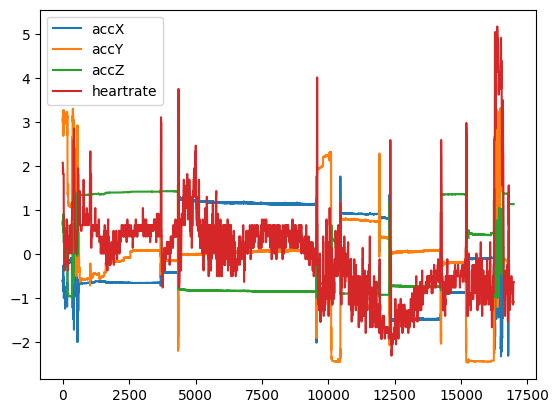

In [18]:
df_feature.plot.line()

<AxesSubplot: >

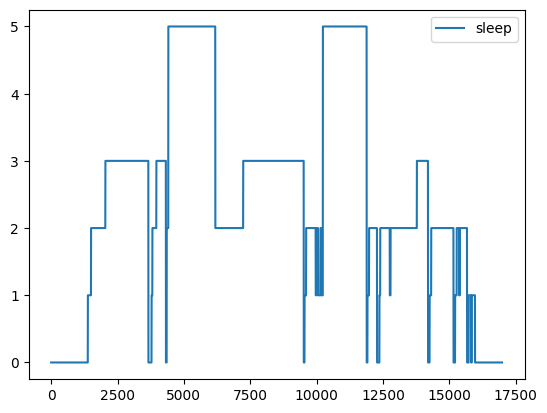

In [19]:
df_label.plot.line()

In [20]:
# ------------ Train-Test-Split 2D features -------------------------------
seed = 42
x_train, x_test, y_train, y_test = model_selection.train_test_split( df_feature, df_label, test_size=0.3, random_state=seed)

In [21]:
slidingW = 100
Stride_step = 5
n_features = 4 
df_feature3D = np.array([],ndmin=2)
df_label_new = np.array([])

for t in range(0 , len(df_feature), Stride_step ):
    F3d = np.array(df_feature[t:t+slidingW],ndmin=2)
    if len(F3d) <slidingW:
        break
    F3d.reshape(slidingW, n_features,1)
    if df_feature3D.size == 0 :
        df_feature3D = F3d
    else:
        df_feature3D = np.dstack((df_feature3D,F3d))
    Labels = stats.mode(df_label[t : t+slidingW])
    df_label_new = np.append(df_label_new,Labels[0])


C:\Users\ACER\AppData\Local\Temp\ipykernel_29464\4025011448.py:16: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  Labels = stats.mode(df_label[t : t+slidingW])


In [22]:
F3d

array([[-1.08121498, -1.09911905,  1.13700377, -0.50104715],
       [-1.08093764, -1.09792365,  1.13793902, -0.50104715],
       [-1.08281078, -1.09874351,  1.13714151, -0.50104715],
       [-1.08311172, -1.09805034,  1.13739179, -0.50104715],
       [-1.08034736, -1.09649515,  1.13830561, -0.50104715],
       [-1.0826026 , -1.09738127,  1.13779902, -0.50104715],
       [-1.08299014, -1.09776666,  1.13724688, -0.50104715],
       [-1.08209192, -1.09651416,  1.13801504, -0.50104715],
       [-1.08216258, -1.09677464,  1.13791832, -0.50104715],
       [-1.08243994, -1.09797627,  1.13671885, -0.50104715],
       [-1.08195894, -1.09773187,  1.13735717, -0.50104715],
       [-1.08120816, -1.09632232,  1.13772863, -0.50104715],
       [-1.08298403, -1.09747939,  1.13714866, -0.50104715],
       [-1.08249694, -1.09793615,  1.13722506, -0.50104715],
       [-1.08089054, -1.09637587,  1.1378852 , -0.50104715],
       [-1.07959642, -1.0963384 ,  1.13828791, -0.50104715],
       [-1.0811109 , -1.

In [23]:
df_feature3D = np.swapaxes(df_feature3D,0,2)
df_feature3D = np.swapaxes(df_feature3D,1,2)
df_feature3D = df_feature3D[..., np.newaxis]

In [24]:
df_feature3D

array([[[[-0.58754699],
         [ 3.05807519],
         [ 0.69872824],
         [ 2.07870531]],

        [[-0.58145574],
         [ 2.99509378],
         [ 0.75774575],
         [ 2.07870531]],

        [[-0.59107524],
         [ 3.02466836],
         [ 0.72269623],
         [ 2.07870531]],

        ...,

        [[-0.92104538],
         [ 3.14574551],
         [ 0.23209668],
         [ 0.27287859]],

        [[-0.91866235],
         [ 3.14714076],
         [ 0.23126907],
         [ 0.27287859]],

        [[-0.90930807],
         [ 3.15256736],
         [ 0.23283358],
         [ 0.27287859]]],


       [[[-0.63079638],
         [ 3.06967162],
         [ 0.66802186],
         [ 1.82073006]],

        [[-0.65623081],
         [ 3.03358303],
         [ 0.6929944 ],
         [ 1.82073006]],

        [[-0.61745949],
         [ 3.04996268],
         [ 0.70392346],
         [ 1.82073006]],

        ...,

        [[-0.92642696],
         [ 3.14347961],
         [ 0.2498879 ],
         [ 0.272

In [25]:
df_label_new

array([0., 0., 0., ..., 0., 0., 0.])

In [26]:
x_train, x_test, y_train, y_test = model_selection.train_test_split( df_feature, df_label, test_size = 0.3, random_state = 42)

In [27]:

x3D_train, x3D_test, y3D_train, y3D_test = model_selection.train_test_split( df_feature3D , df_label_new,test_size = 0.33 ,random_state=2)

In [28]:
# ------------ NN Architecture parameter -------------------------------
Hidden_Layer_param = (30, 30, 30)
mlp = MLPClassifier(hidden_layer_sizes = Hidden_Layer_param)
# View NN model parameters

In [29]:
mlp

MLPClassifier(hidden_layer_sizes=(30, 30, 30))

In [30]:
mlp.fit(x_train,y_train)
smlp_pred = mlp.predict(x_test)

c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [31]:
y_test

,sleep
13205,2.0
6393,2.0
608,0.0
4745,5.0
12036,2.0
...,...
5148,5.0
1369,0.0
740,0.0
5527,5.0


In [32]:
smlp_pred[0]

2.0

In [33]:
print('Confusion Matrix of smlp_pred: ')
print(confusion_matrix(y_test, smlp_pred))
print('Classification Report of smlp_preds: ')
print(classification_report(y_test, smlp_pred))

Confusion Matrix of smlp_pred: 
[[ 686   21  112   29    8]
 [  16  131   88    2    8]
 [  14   25 1403   59   21]
 [   0    0   68 1391    0]
 [   1    3   64    0  945]]
Classification Report of smlp_preds: 
              precision    recall  f1-score   support

         0.0       0.96      0.80      0.87       856
         1.0       0.73      0.53      0.62       245
         2.0       0.81      0.92      0.86      1522
         3.0       0.94      0.95      0.95      1459
         5.0       0.96      0.93      0.95      1013

    accuracy                           0.89      5095
   macro avg       0.88      0.83      0.85      5095
weighted avg       0.90      0.89      0.89      5095



In [34]:
# ------------ CNN Architecture parameter -------------------------------
# Nlayer (CNN, dense), Nnode, Activation
CNN_L1 = 16
CNN_L2 = 64
CNN_L3 = 128
D_L1 = 512
D_out = 6
n_feature = 4
Act_func = "relu"
Ker_size = (3,3)
Pooling_size = (2,1)
Input_shape = (slidingW, n_feature, 1)

In [35]:
# ------------ Create CNN Model -------------------------------
model = models.Sequential()
model.add(layers.Conv2D(CNN_L1, kernel_size=Ker_size, activation=Act_func,input_shape=Input_shape,padding='same'))
model.add(layers.MaxPooling2D(pool_size=Pooling_size))
model.add(layers.Dropout(0.4))
model.add(layers.Conv2D(CNN_L2, kernel_size=Ker_size, activation= Act_func, padding='same'))
model.add(layers.MaxPooling2D(pool_size= Pooling_size))
model.add(layers.Dropout(0.4))
model.add(layers.Conv2D(CNN_L3, kernel_size=Ker_size, activation= Act_func,padding='same'))
model.add(layers.MaxPooling2D(pool_size= Pooling_size))
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(D_L1 , activation= Act_func ))
model.add(layers.Dense(D_out, activation='sigmoid'))
model.compile(optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 4, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 4, 16)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 50, 4, 16)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 4, 64)         9280      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 4, 64)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 25, 4, 64)         0

In [36]:
# ------------ Create Optimizer -------------------------------
model.compile(optimizer='adam',loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=["acc"])

In [37]:
# ------ Train CNN using 3D feature--------------------------------------------
history = model.fit(x3D_train, y3D_train, epochs=50, batch_size=64,validation_data=(x3D_test, y3D_test))

Epoch 1/50


c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


36/36 [==============================] - 5s 107ms/step - loss: 1.1984 - acc: 0.4823 - val_loss: 0.9292 - val_acc: 0.6332
Epoch 2/50
36/36 [==============================] - 3s 87ms/step - loss: 0.6794 - acc: 0.7034 - val_loss: 0.6037 - val_acc: 0.7650
Epoch 3/50
36/36 [==============================] - 3s 90ms/step - loss: 0.5366 - acc: 0.7759 - val_loss: 0.4805 - val_acc: 0.8179
Epoch 4/50
36/36 [==============================] - 3s 88ms/step - loss: 0.4805 - acc: 0.7882 - val_loss: 0.4964 - val_acc: 0.8413
Epoch 5/50
36/36 [==============================] - 3s 87ms/step - loss: 0.4644 - acc: 0.7922 - val_loss: 0.4566 - val_acc: 0.8251
Epoch 6/50
36/36 [==============================] - 3s 95ms/step - loss: 0.4368 - acc: 0.8042 - val_loss: 0.5417 - val_acc: 0.7426
Epoch 7/50
36/36 [==============================] - 4s 115ms/step - loss: 0.4079 - acc: 0.8240 - val_loss: 0.3729 - val_acc: 0.8601
Epoch 8/50
36/36 [==============================] - 4s 110ms/step - loss: 0.3591 - acc: 0.85

In [38]:
CNN_pred = model.predict(x3D_test)

35/35 [==============================] - 0s 11ms/step


In [39]:
CNN_pred[0]

array([3.6744893e-01, 2.8739641e-12, 9.7398603e-01, 9.9999982e-01,
       5.4074039e-06, 7.7407385e-06], dtype=float32)

In [40]:
y3D_test[0]

3.0

In [41]:
print(utils.multiclass.type_of_target(CNN_pred))

continuous-multioutput


In [46]:
CNN_pred = np.argmax(model.predict(x3D_test),axis=1)

35/35 [==============================] - 1s 16ms/step


In [47]:
print(utils.multiclass.type_of_target(CNN_pred))

multiclass


In [48]:
print('Confusion Matrix of smlp_pred: ')
print(confusion_matrix(y3D_test, CNN_pred))
print('Classification Report of smlp_preds: ')
print(classification_report(y3D_test, CNN_pred))

Confusion Matrix of smlp_pred: 
[[171   4   9   0   0]
 [  4  44   8   0   1]
 [  2   4 311  12   8]
 [  0   0   7 318   0]
 [  0   0   0   0 212]]
Classification Report of smlp_preds: 
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95       184
         1.0       0.85      0.77      0.81        57
         2.0       0.93      0.92      0.93       337
         3.0       0.96      0.98      0.97       325
         5.0       0.96      1.00      0.98       212

    accuracy                           0.95      1115
   macro avg       0.93      0.92      0.93      1115
weighted avg       0.95      0.95      0.95      1115



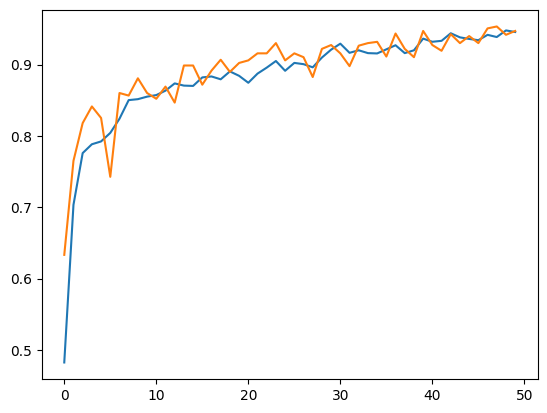

In [49]:
# ------ View History Graph -------------------------------------------
# View Accuracy Graph
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()


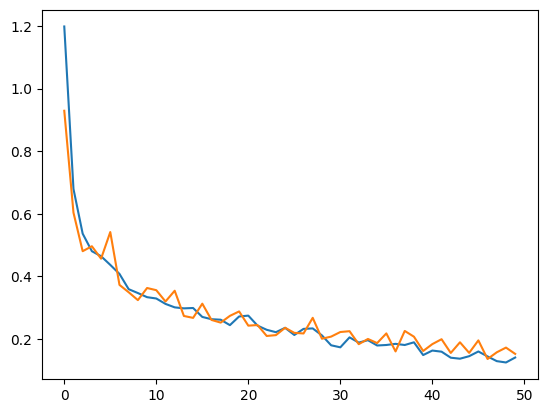

In [50]:
# View Loss Graph
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()